# Task 2

#The Functions for computing Permutation Entropy and Complexity were referenced from the following github page:
https://github.com/srk-srinivasan/Permutation-Entropy/blob/master/p_entropy.py    

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
''' This module has essential functions supporting
fast and effective computation of permutation entropy and
its different variations.'''
import numpy as np


def s_entropy(freq_list):
    ''' This function computes the shannon entropy of a given frequency distribution.
    USAGE: shannon_entropy(freq_list)
    ARGS: freq_list = Numeric vector representing the frequency distribution
    OUTPUT: A numeric value representing shannon's entropy'''
    freq_list = [element for element in freq_list if element != 0]
    sh_entropy = 0.0
    for freq in freq_list:
        sh_entropy += freq * np.log(freq)
    sh_entropy = -sh_entropy
    return(sh_entropy)

def ordinal_patterns(ts, embdim, embdelay):
    ''' This function computes the ordinal patterns of a time series for a given embedding dimension and embedding delay.
    USAGE: ordinal_patterns(ts, embdim, embdelay)
    ARGS: ts = Numeric vector representing the time series, embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: A numeric vector representing frequencies of ordinal patterns'''
    m, t = embdim, embdelay
    x = ts if isinstance(ts, np.ndarray) else np.array(ts) 

    tmp = np.zeros((x.shape[0], m))
    for i in range(m):
        tmp[:, i] = np.roll(x, i*t)
    partition = tmp[(t*(m-1)):, :] 
    permutation = np.argsort(partition)
    idx = _hash(permutation)

    counts = np.zeros(np.math.factorial(m))
    for i in range(counts.shape[0]):
        counts[i] = (idx == i).sum()
    return list(counts[counts != 0].astype(int))

def _hash(x):
    m, n = x.shape
    if n == 1:
        return np.zeros(m)
    return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:]) 
    

def p_entropy(op):
    ordinal_pat = op
    max_entropy = np.log(len(ordinal_pat))
    p = np.divide(np.array(ordinal_pat), float(sum(ordinal_pat)))
    return(s_entropy(p)/max_entropy)

def complexity(op):
    ''' This function computes the complexity of a time series defined as: Comp_JS = Q_o * JSdivergence * pe
    Q_o = Normalizing constant
    JSdivergence = Jensen-Shannon divergence
    pe = permutation entopry
    ARGS: ordinal pattern'''
    pe = p_entropy(op)
    constant1 = (0.5+((1 - 0.5)/len(op)))* np.log(0.5+((1 - 0.5)/len(op)))
    constant2 = ((1 - 0.5)/len(op))*np.log((1 - 0.5)/len(op))*(len(op) - 1)
    constant3 = 0.5*np.log(len(op))
    Q_o = -1/(constant1+constant2+constant3)

    temp_op_prob = np.divide(op, sum(op))
    temp_op_prob2 = (0.5*temp_op_prob)+(0.5*(1/len(op)))
    JSdivergence = (s_entropy(temp_op_prob2) - 0.5 * s_entropy(temp_op_prob) - 0.5 * np.log(len(op)))
    Comp_JS = Q_o * JSdivergence * pe
    return(Comp_JS)

def weighted_ordinal_patterns(ts, embdim, embdelay):
    m, t = embdim, embdelay
    x = ts if isinstance(ts, np.ndarray) else np.array(ts) 

    tmp = np.zeros((x.shape[0], m))
    for i in range(m):
        tmp[:, i] = np.roll(x, i*t)
    xm = np.mean(partition, axis=1)
    weight = np.mean((partition - xm[:, None])**2, axis=1)
    permutation = np.argsort(partition)
    idx = _hash(permutation)
    counts = np.zeros(np.math.factorial(m))
    for i in range(counts.shape[0]):
        counts[i] = sum(weight[i == idx])

    return list(counts[counts != 0]) 

In [4]:
#Creating Empty Dataframe to Store Results.
#Iterating Over Subjects, Activity, Body Parts, Axis, Signal Length, Dimension and Delay. . Calling the Function. 
#Appending it to the final dataframe.
dffinal = pd.DataFrame(columns = ['Sub', 'Axis', 'Signal Length', 'Dimension', 'Delay', 'Permutation Entropy', 'Complexity', 'Activity', 'BodyP']) 
for sub in range(1,16):
    for act in ['walking','running','climbingup','climbingdown']:
        for bodyp in ['head','chest']:
#All 120 CSV Files Were Read on Local Machine           
            dfname = pd.read_csv('Sub'+str(sub)+'_acc_'+act+'_'+bodyp+'.csv')
            for ax in ['attr_x','attr_y','attr_z']:
                for sig in [2024, 3048, 5096]:
                    ts = dfname[ax][1000:sig]
                    for embdim in [3,4,5,6]:
                        for embdelay in [1,2,3]:

                            op = ordinal_patterns(ts,embdim,embdelay)
                            perm_ent = p_entropy(op)
                            comp = complexity(op)
                            dffinal = dffinal.append({'Sub':sub,'Axis':ax, 'Signal Length':sig-1000, 'Dimension':embdim, 'Delay':embdelay,'Permutation Entropy':perm_ent,'Complexity': comp, 'Activity':act, 'BodyP': bodyp},ignore_index=True) 
                            
dffinal


,Sub,Axis,Signal Length,Dimension,Delay,Permutation Entropy,Complexity,Activity,BodyP
0,1,attr_x,1024,3,1,0.848094,0.124252,walking,head
1,1,attr_x,1024,3,2,0.906205,0.081132,walking,head
2,1,attr_x,1024,3,3,0.933534,0.057655,walking,head
3,1,attr_x,1024,4,1,0.789499,0.193295,walking,head
4,1,attr_x,1024,4,2,0.853442,0.149482,walking,head
...,...,...,...,...,...,...,...,...,...
12955,15,attr_z,4096,5,2,0.930673,0.113589,climbingdown,chest
12956,15,attr_z,4096,5,3,0.967689,0.058713,climbingdown,chest
12957,15,attr_z,4096,6,1,0.838598,0.246194,climbingdown,chest
12958,15,attr_z,4096,6,2,0.930232,0.145781,climbingdown,chest


# VISUALIZATION

# Permutation Entropy Vs Complexity for Body Part as Head and Activity as Walking Or Running

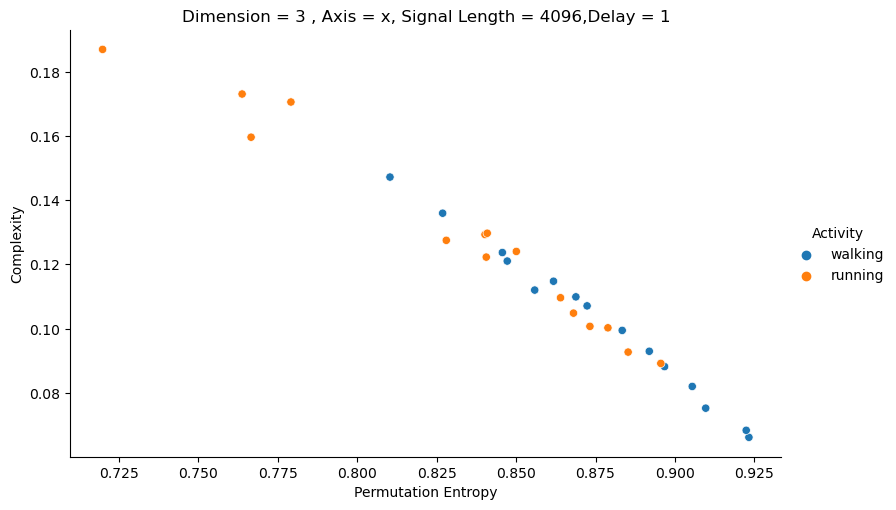

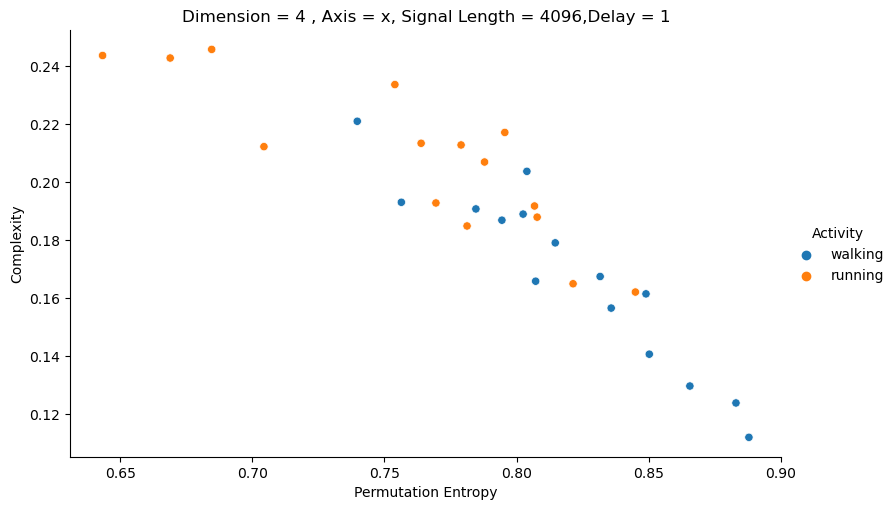

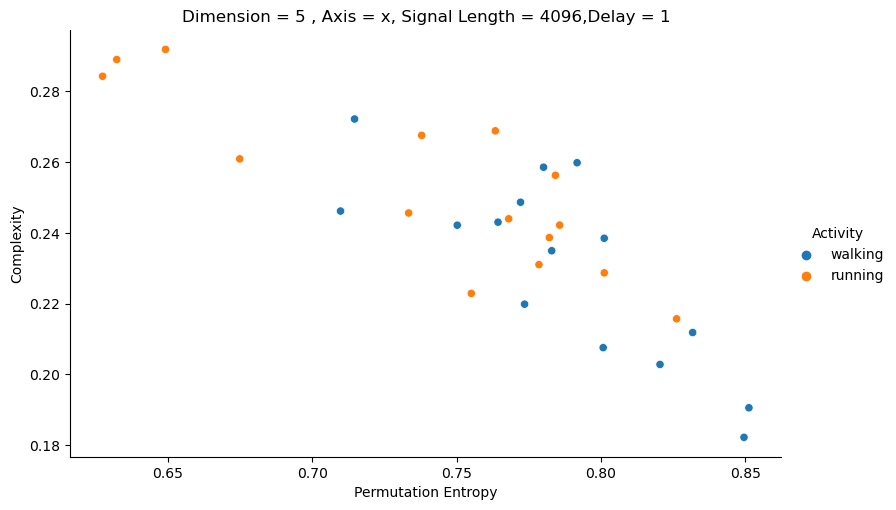

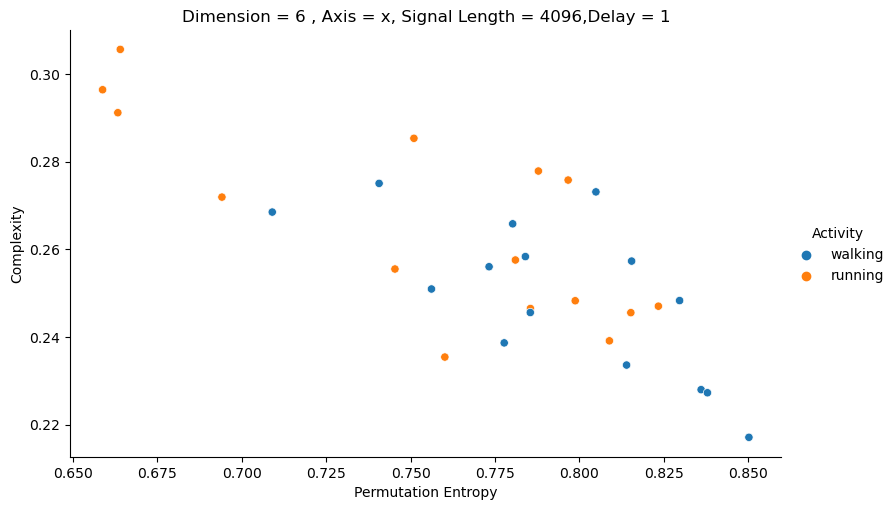

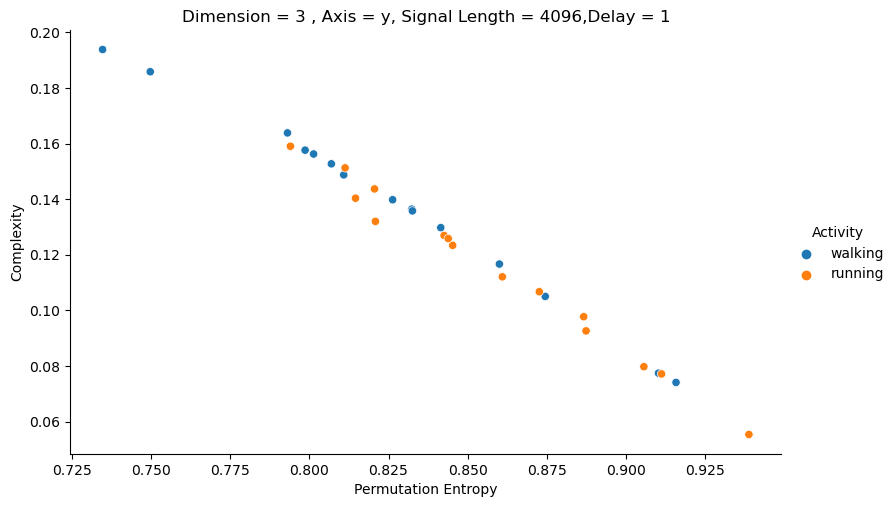

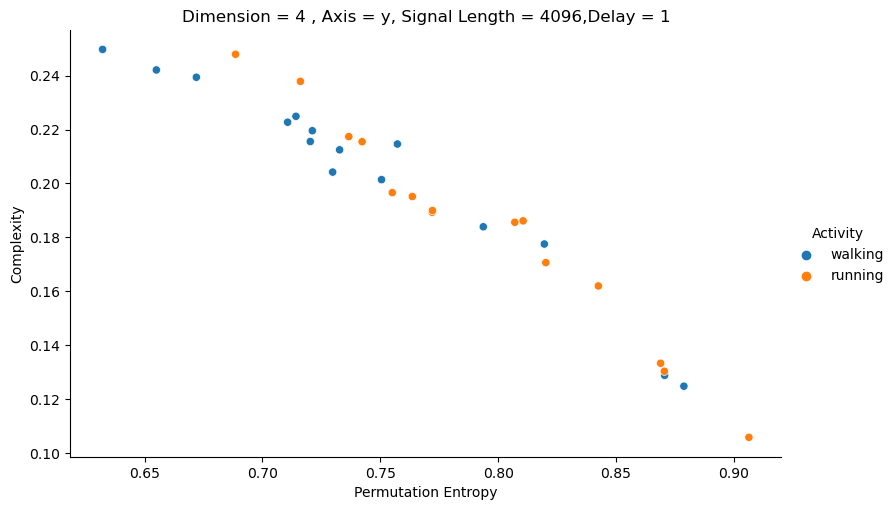

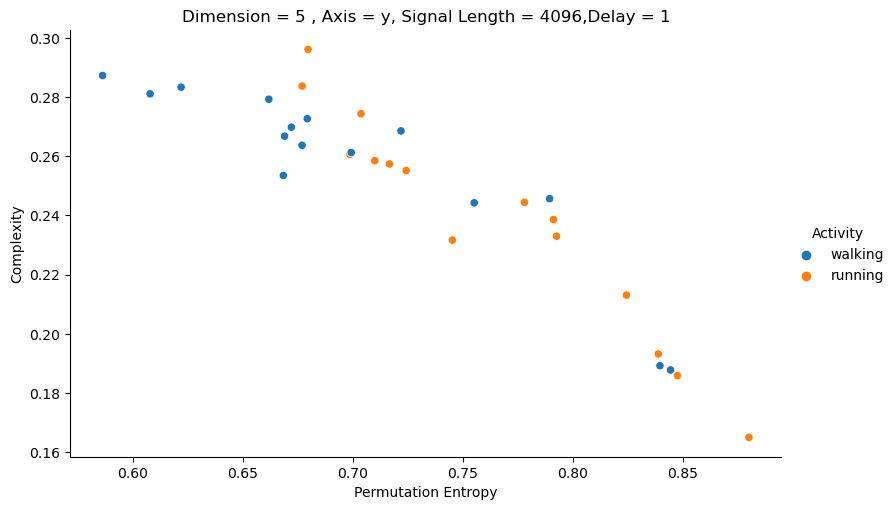

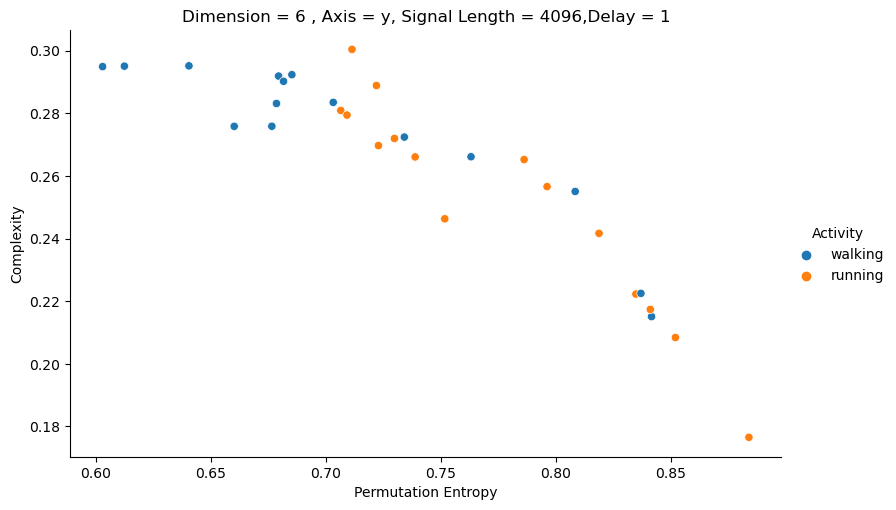

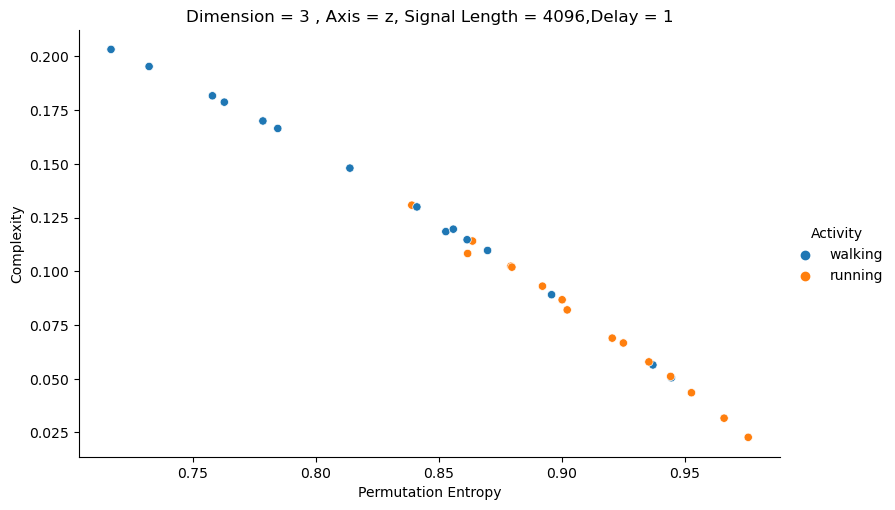

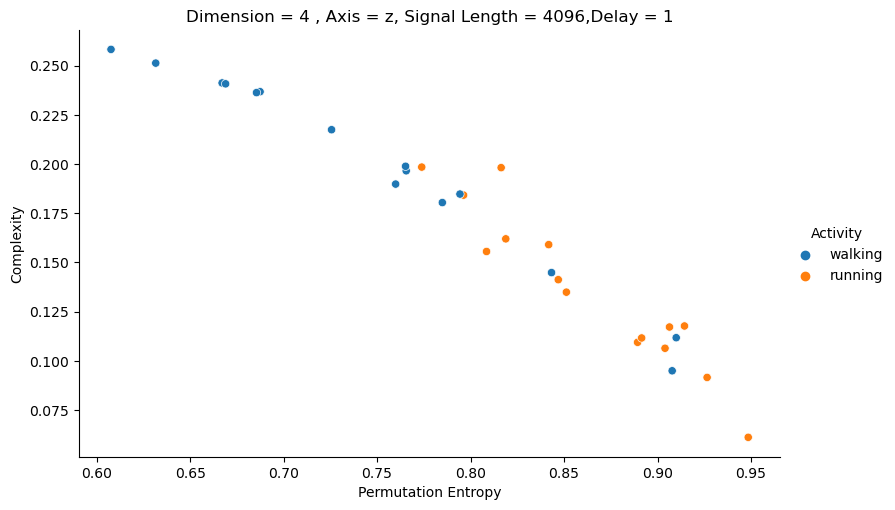

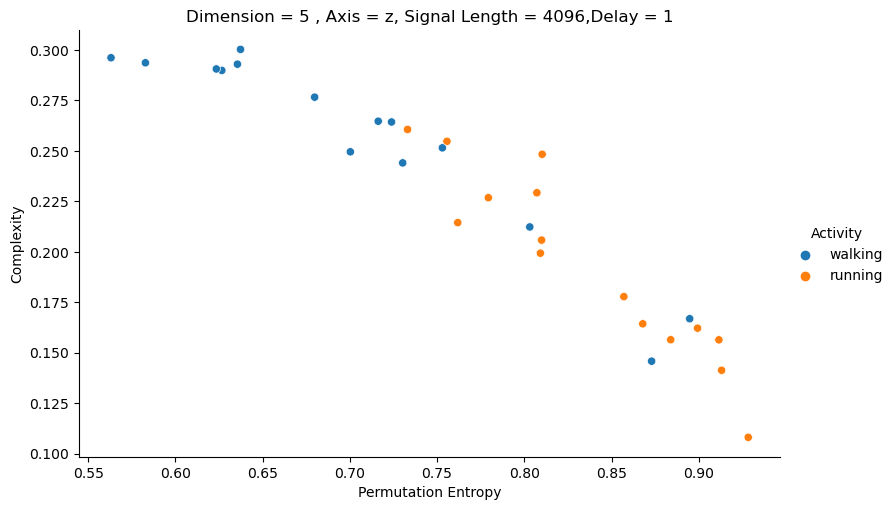

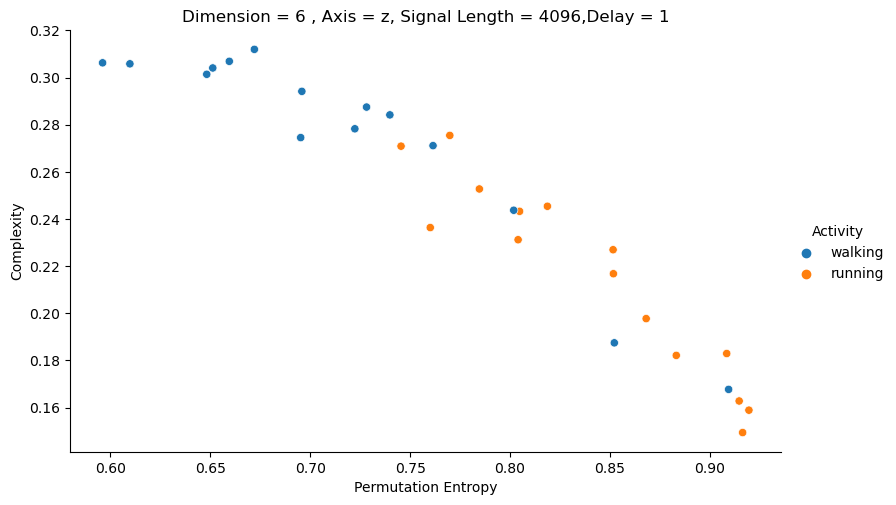

In [5]:
for ax in ['attr_x','attr_y','attr_z']:
    for dim in [3,4,5,6]:
        dfplt = dffinal[(dffinal['BodyP'] == 'head') & (dffinal['Signal Length'] == 4096) & (dffinal['Delay'] == 1 ) & (dffinal['Dimension'] == dim ) & (dffinal['Axis'] == ax ) & ((dffinal['Activity'] == 'walking') | (dffinal['Activity'] == 'running'))]
        sns.relplot(data=dfplt, x='Permutation Entropy', y='Complexity', hue='Activity', aspect=1.61).set(title='Dimension = '+str(dim)+' , Axis = '+ax[5:]+', Signal Length = 4096'+',Delay = 1')
    
        plt.show()
        

# Permutation Entropy Vs Complexity for Body Part as Chest and Activity as Walking Or Running

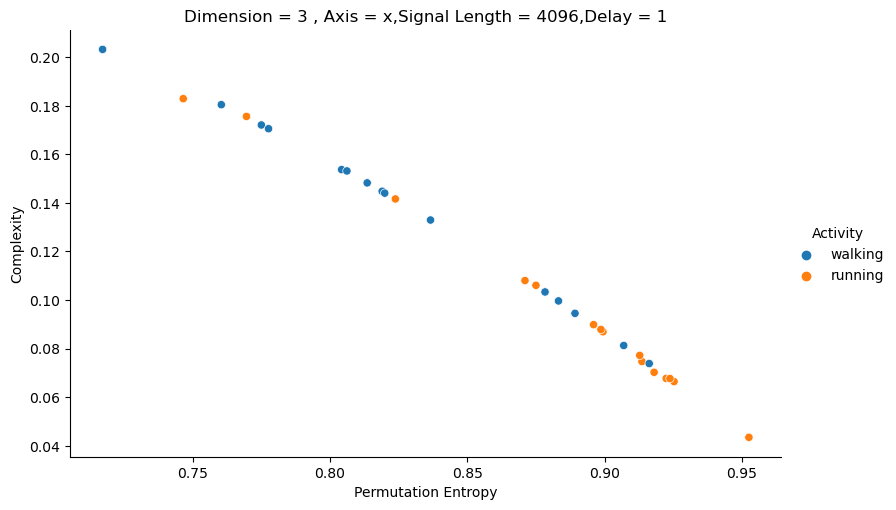

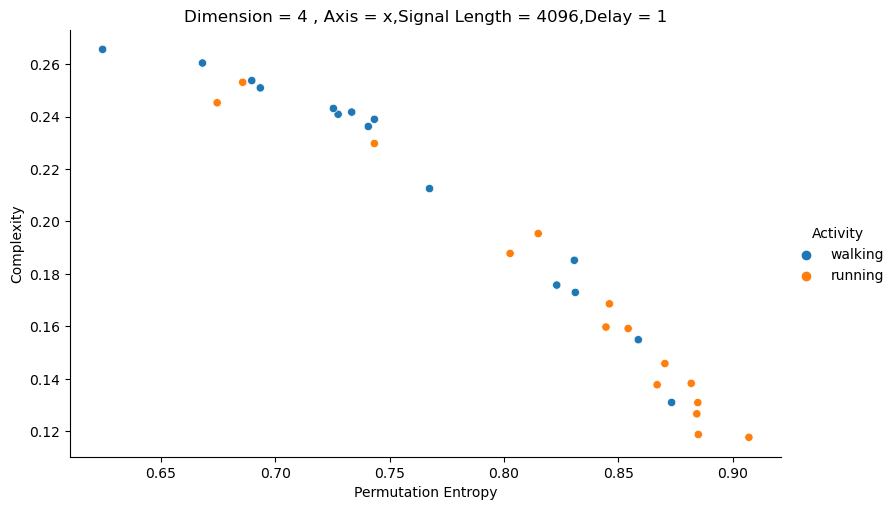

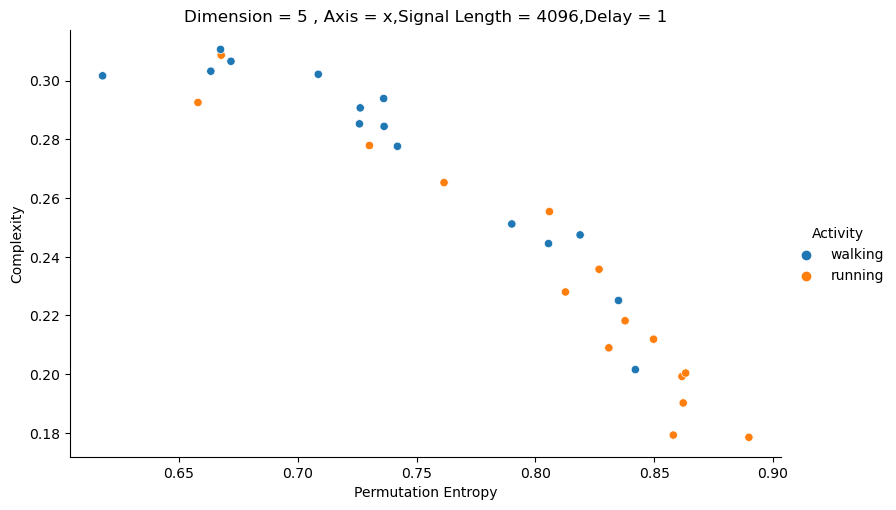

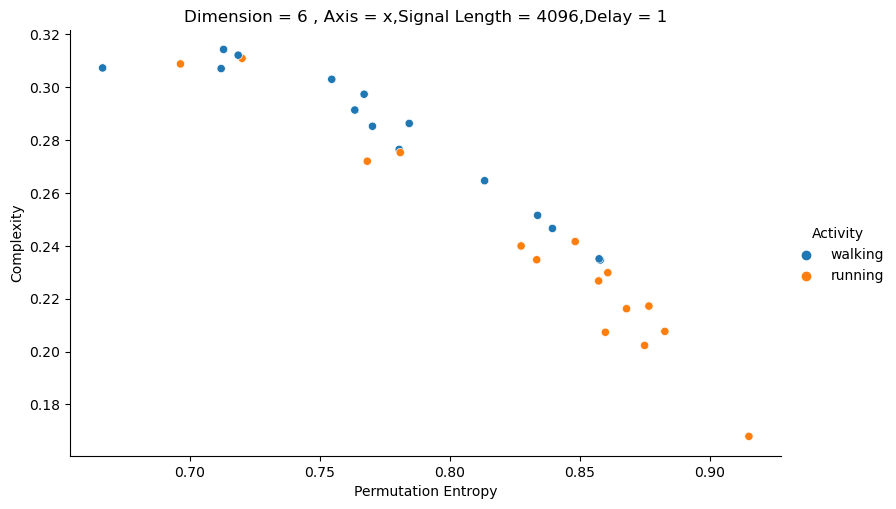

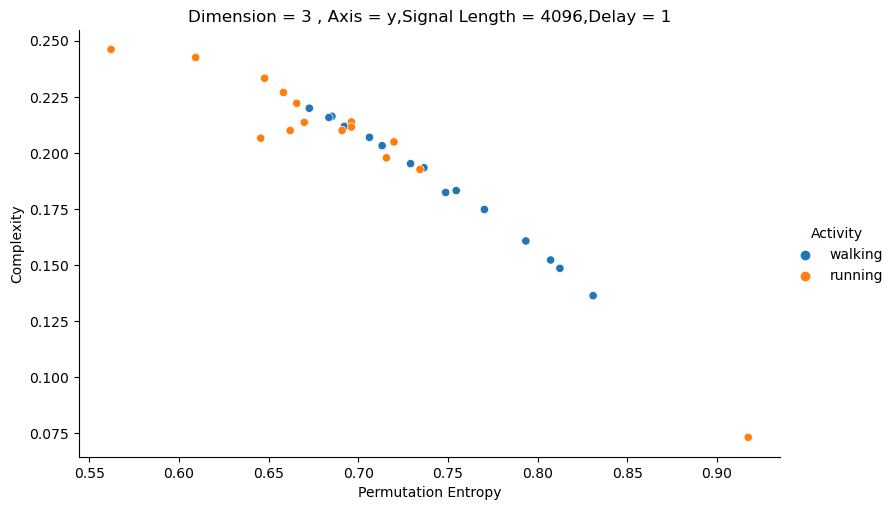

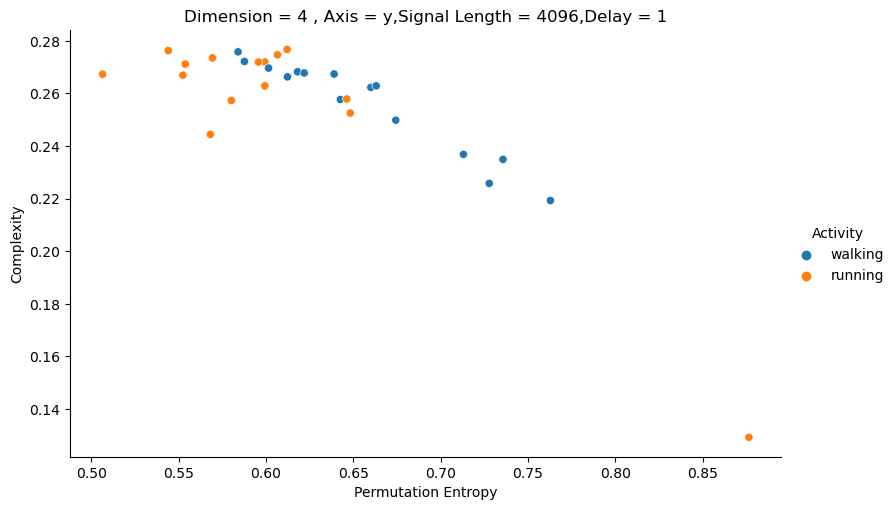

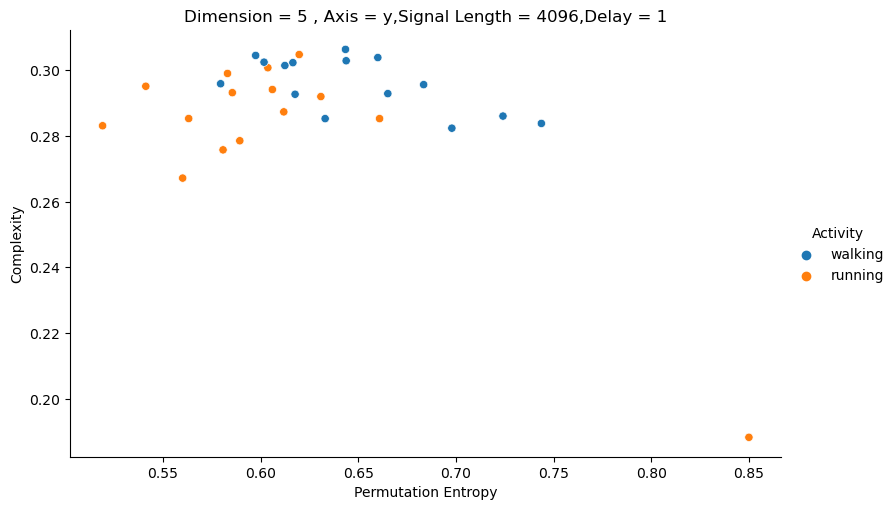

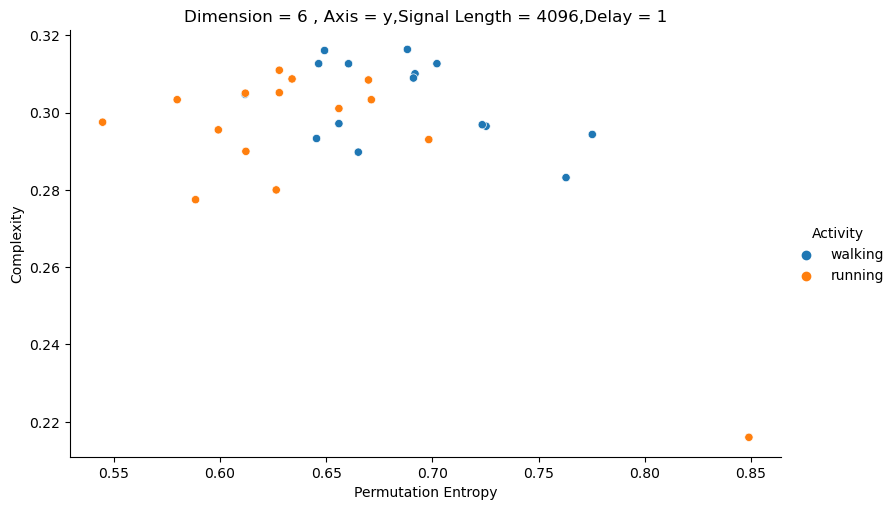

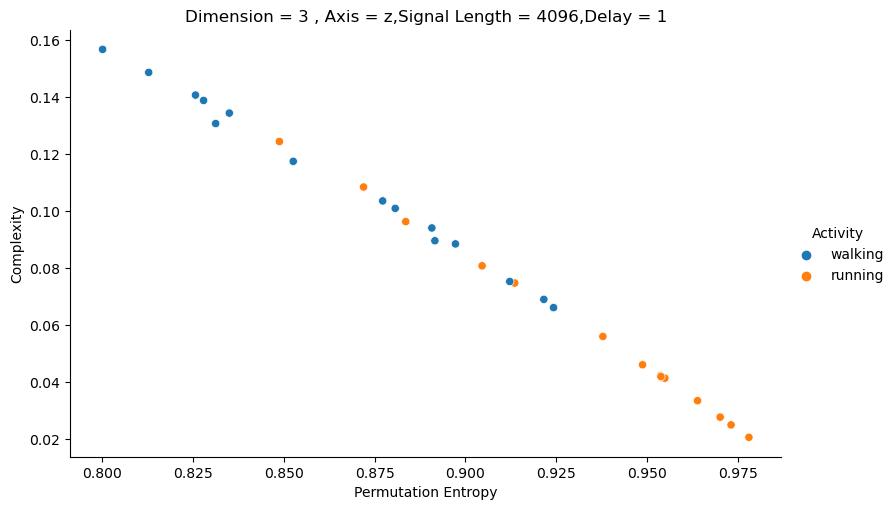

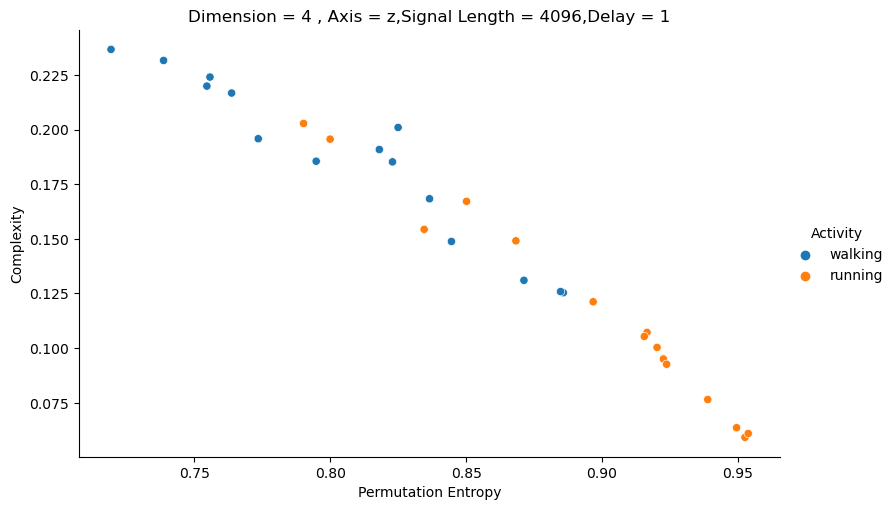

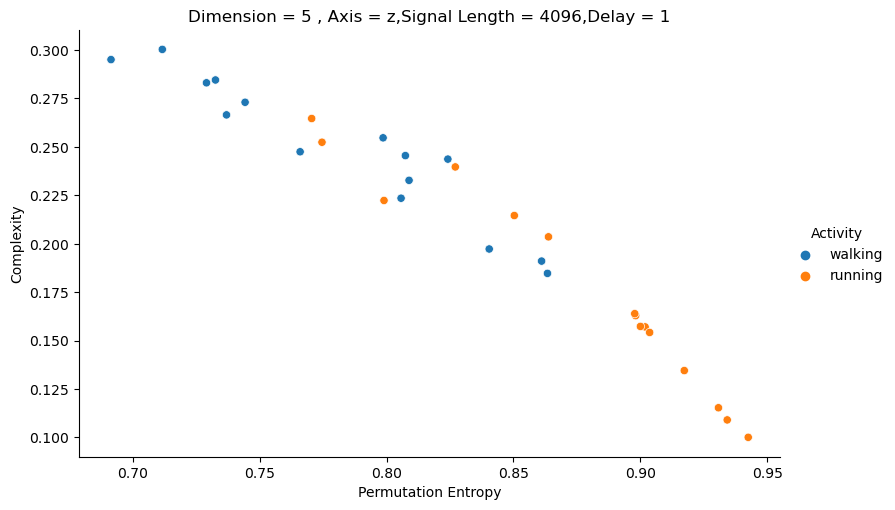

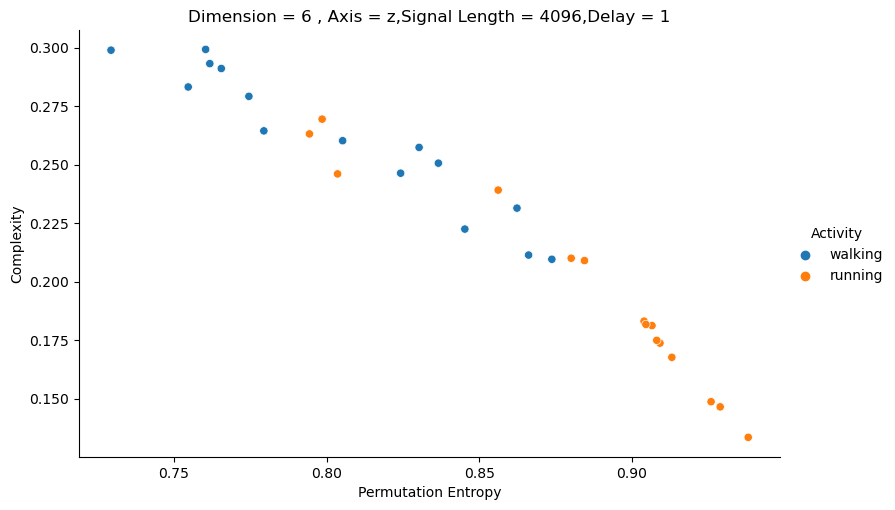

In [6]:
for ax in ['attr_x','attr_y','attr_z']:
    for dim in [3,4,5,6]:
        dff = dffinal[(dffinal['BodyP'] == 'chest') & (dffinal['Signal Length'] == 4096) & (dffinal['Delay'] == 1 ) & (dffinal['Dimension'] == dim ) & (dffinal['Axis'] == ax ) & ((dffinal['Activity'] == 'walking') | (dffinal['Activity'] == 'running'))]
        sns.relplot(data=dff, x='Permutation Entropy', y='Complexity', hue='Activity', aspect=1.61).set(title='Dimension = '+str(dim)+' , Axis = '+ax[5:]+ ',Signal Length = 4096'+',Delay = 1')
    
        plt.show()

# Permutation Entropy Vs Complexity for Body Part as Head and Activity as ClimbingUp Or ClimbingDown

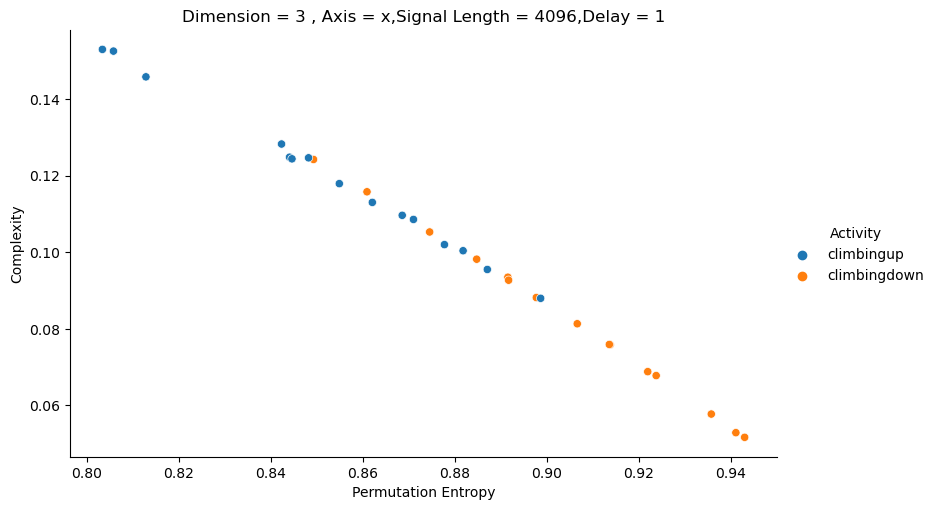

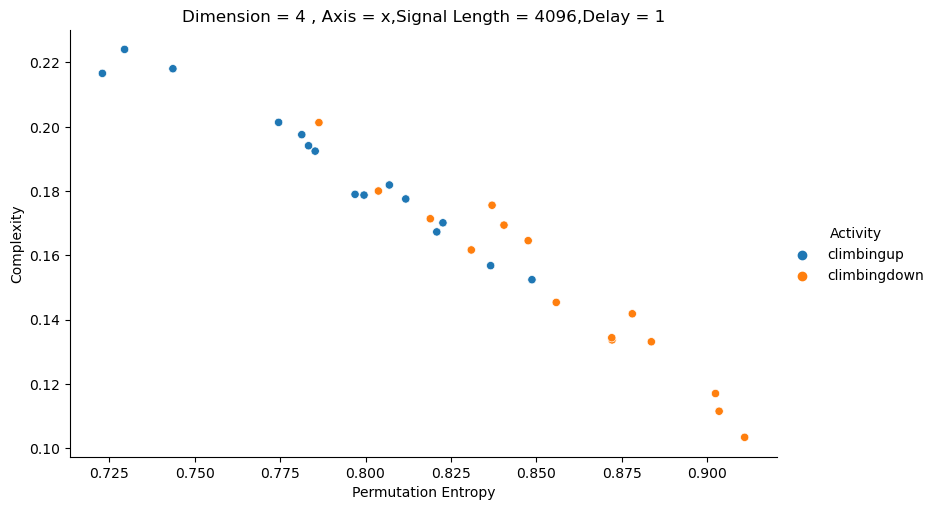

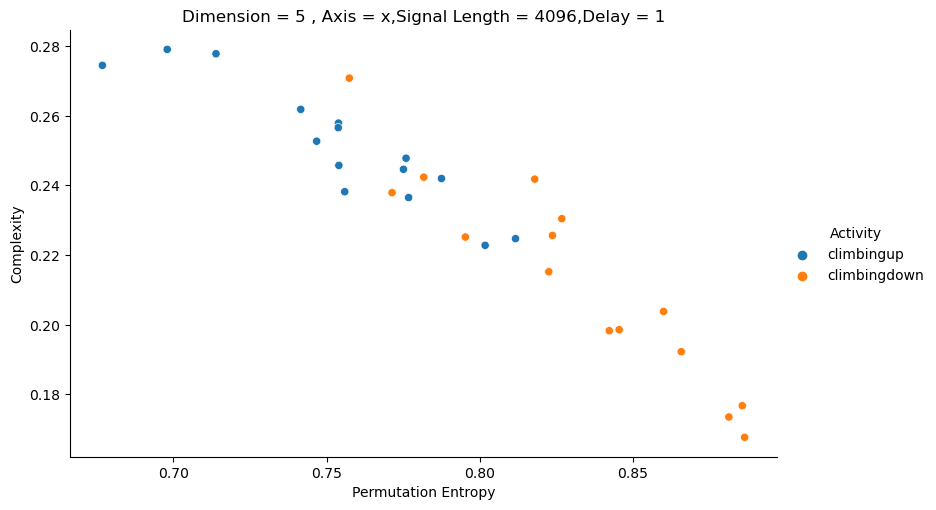

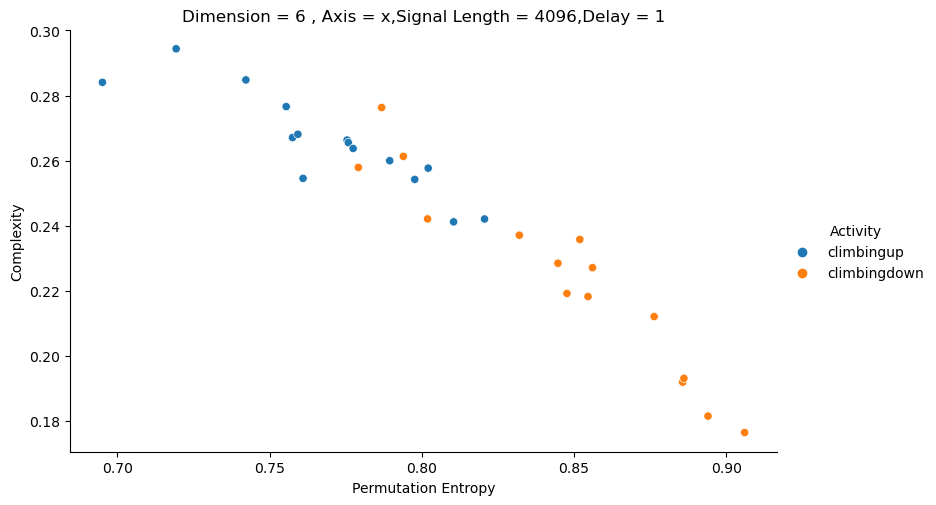

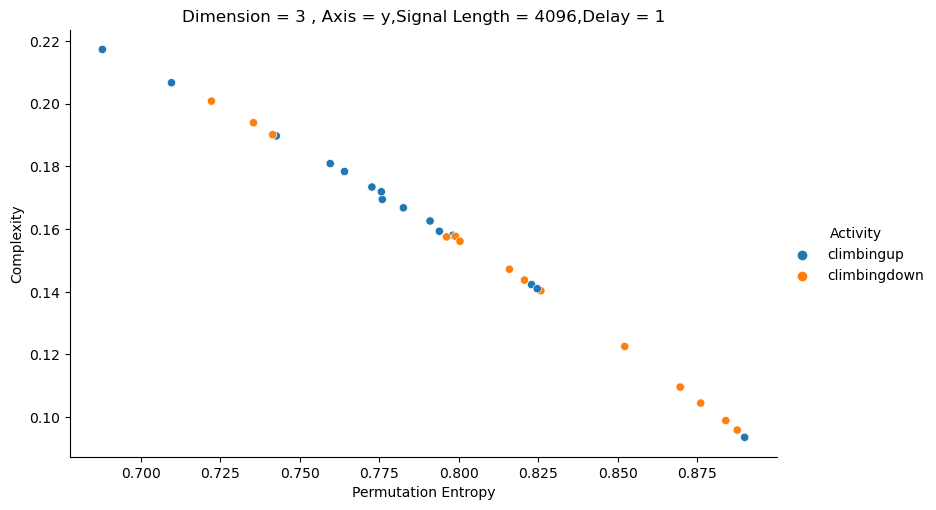

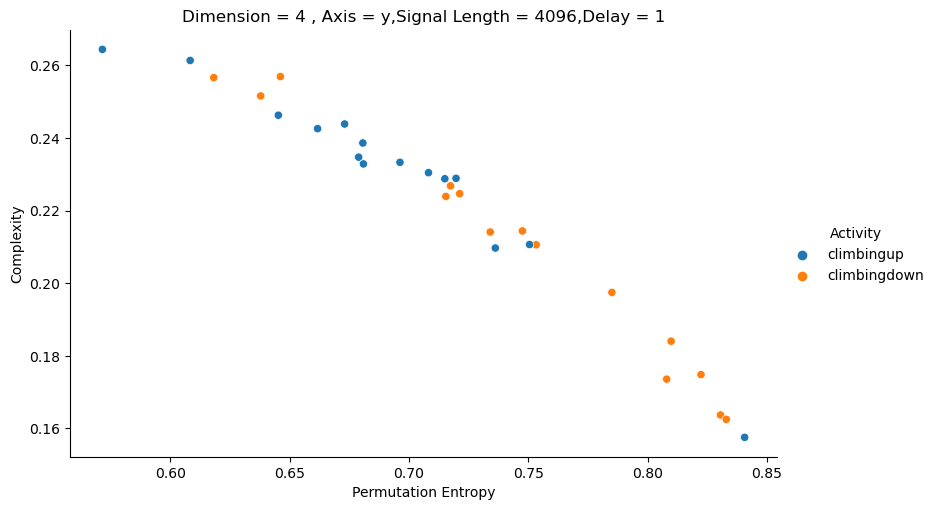

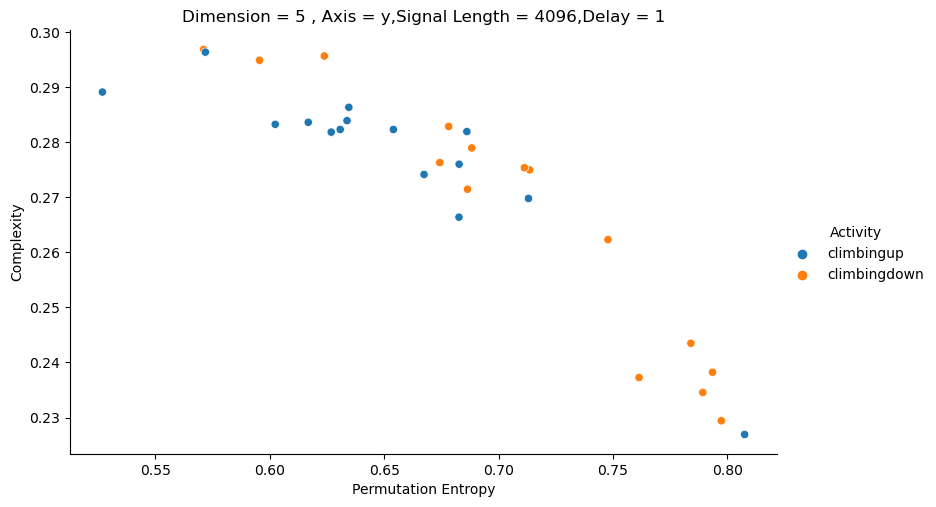

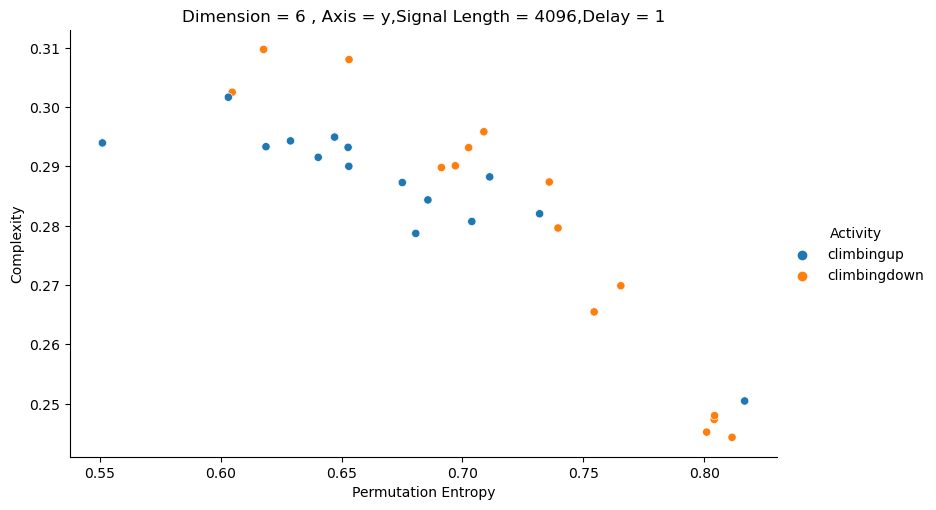

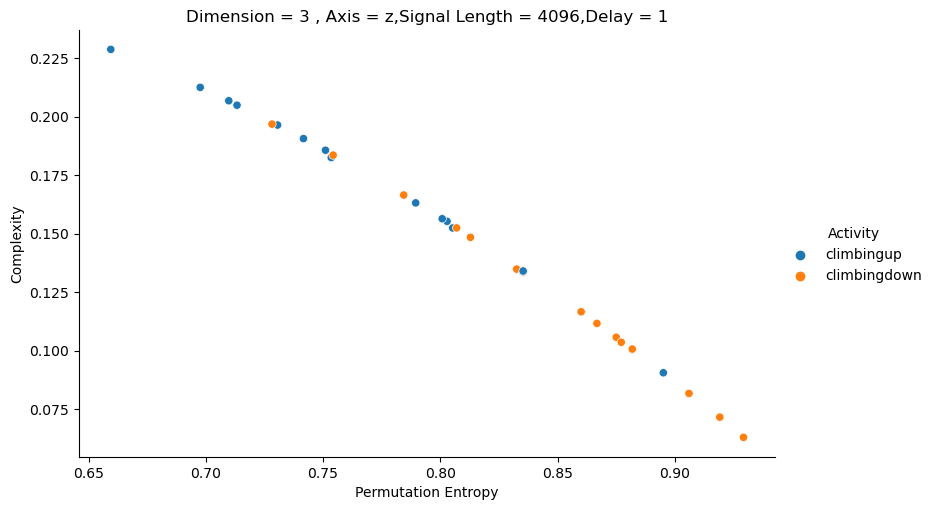

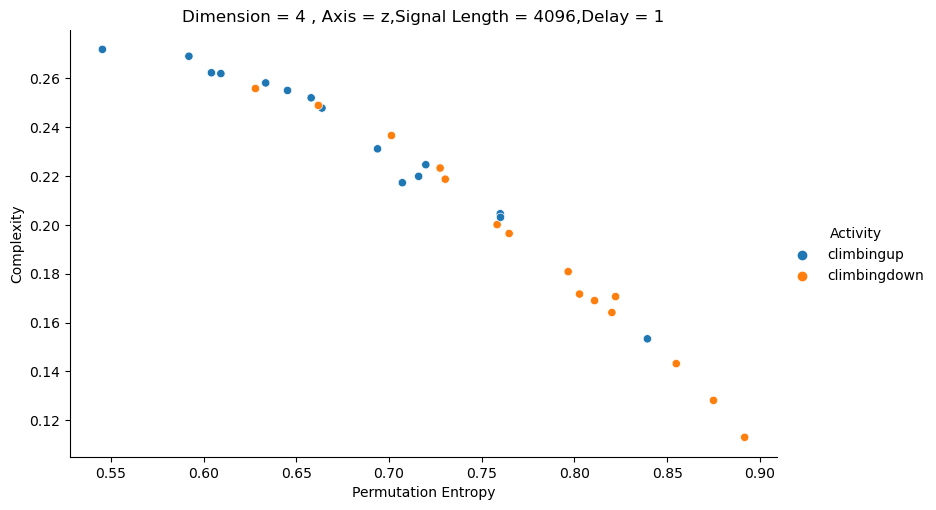

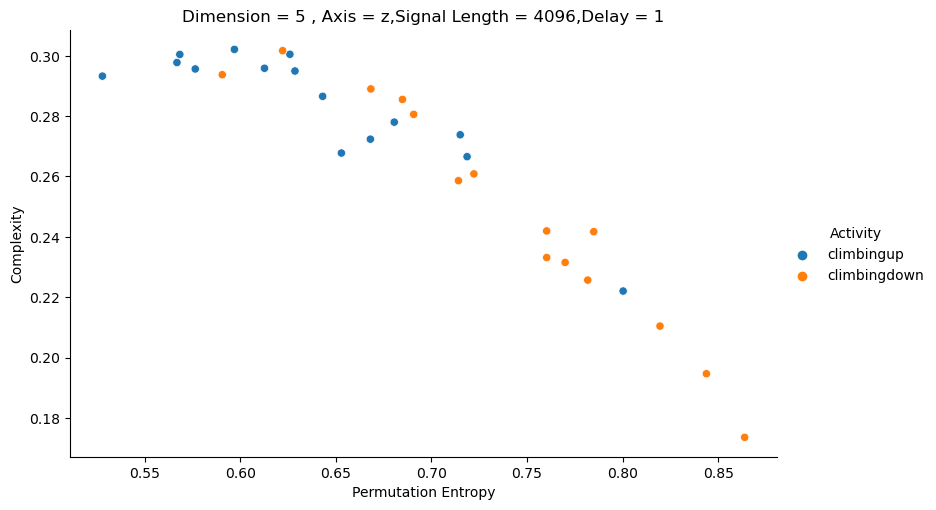

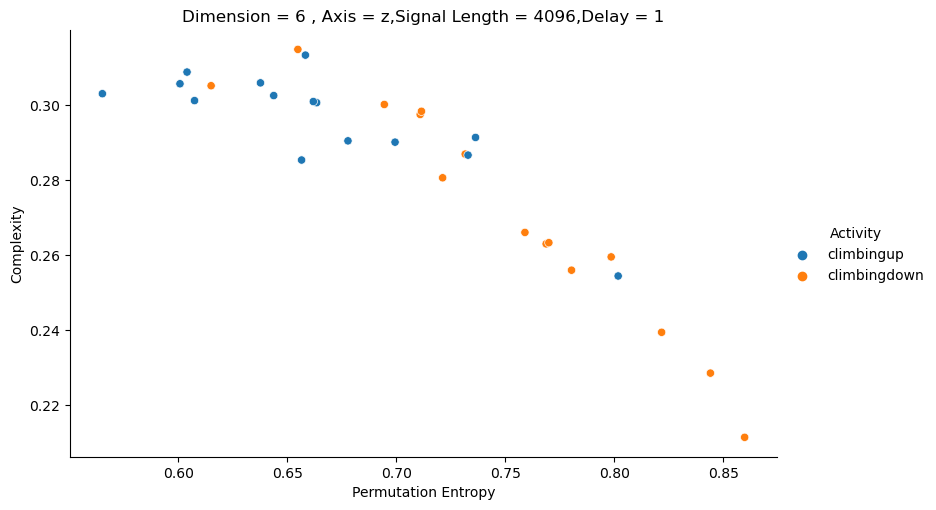

In [7]:
for ax in ['attr_x','attr_y','attr_z']:
    for dim in [3,4,5,6]:
        dff = dffinal[(dffinal['BodyP'] == 'head') & (dffinal['Signal Length'] == 4096) & (dffinal['Delay'] == 1 ) & (dffinal['Dimension'] == dim ) & (dffinal['Axis'] == ax ) & ((dffinal['Activity'] == 'climbingup') | (dffinal['Activity'] == 'climbingdown'))]
        sns.relplot(data=dff, x='Permutation Entropy', y='Complexity', hue='Activity', aspect=1.61).set(title='Dimension = '+str(dim)+' , Axis = '+ax[5:]+ ',Signal Length = 4096'+',Delay = 1')
    
        plt.show()

# Permutation Entropy Vs Complexity for Body Part as Chest and Activity as ClimbingUp Or ClimbingDown

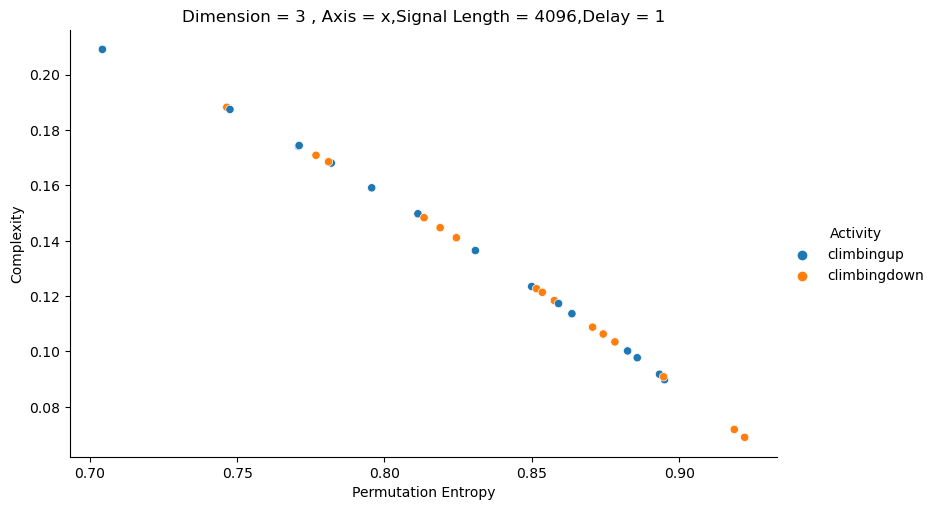

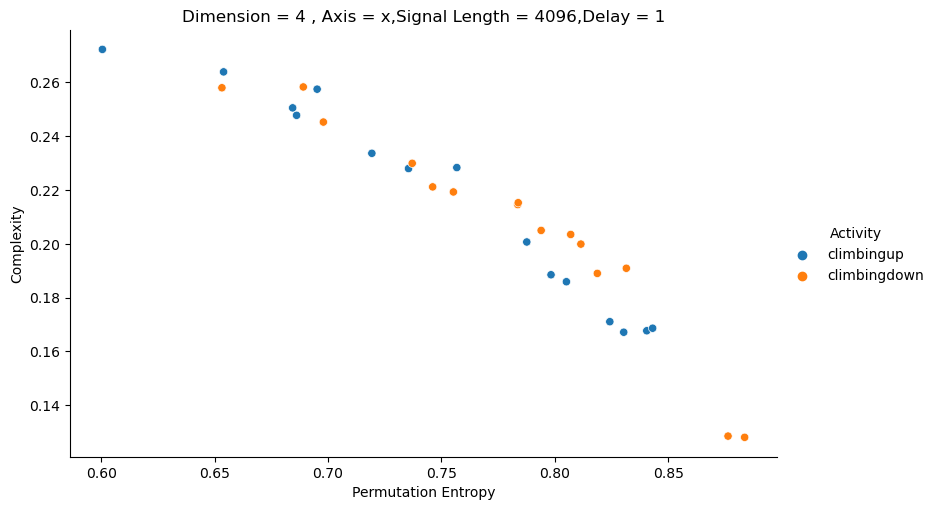

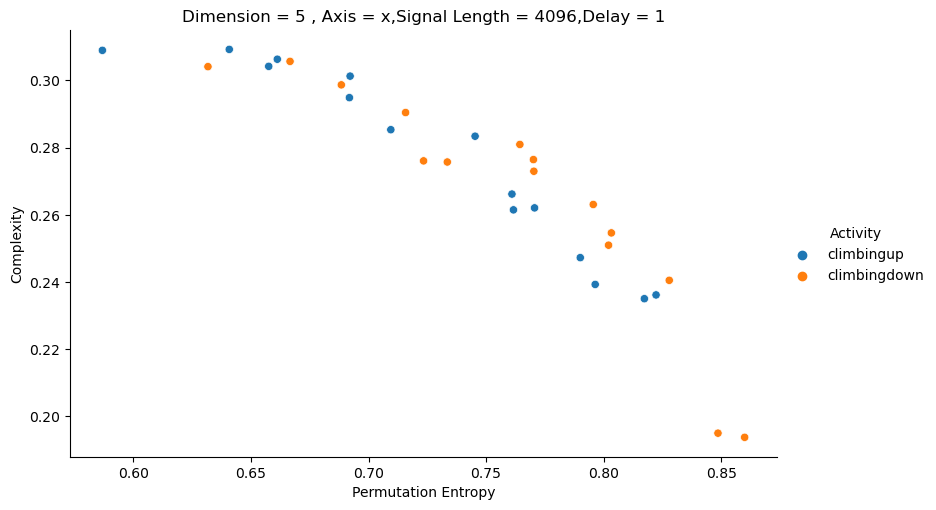

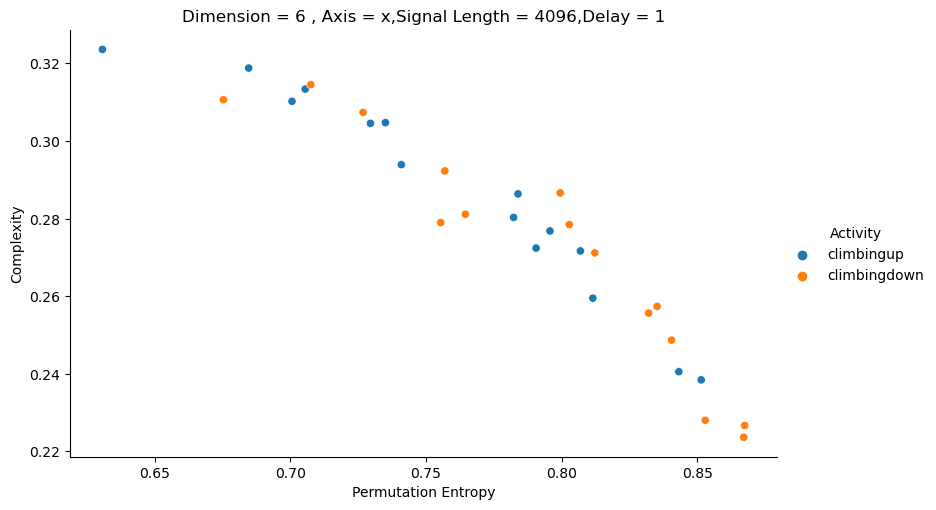

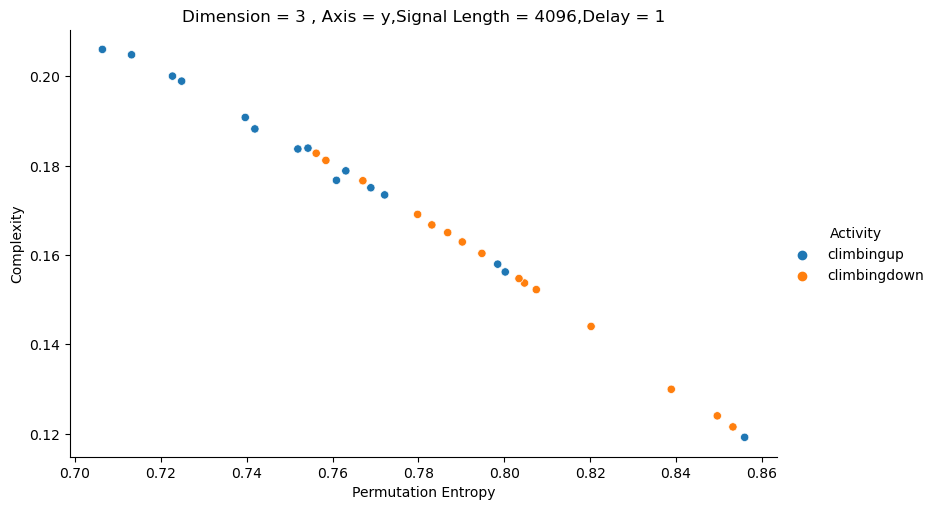

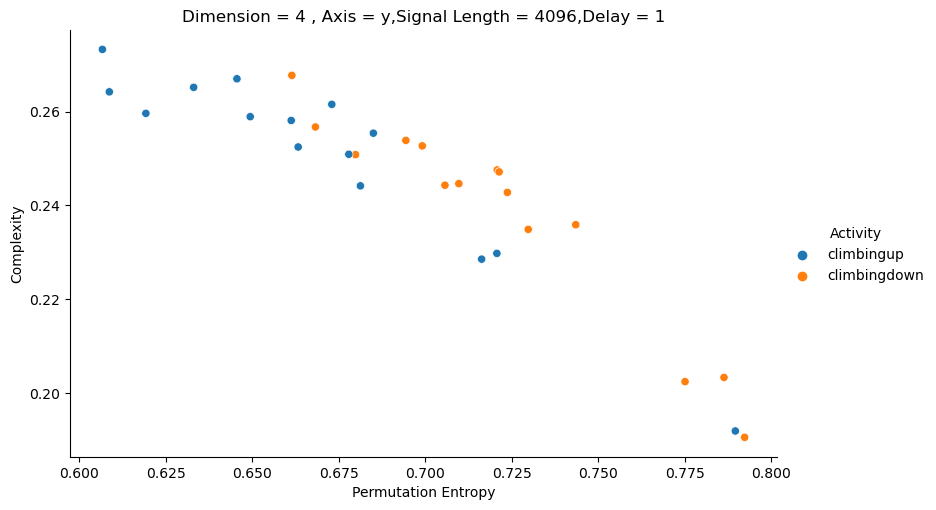

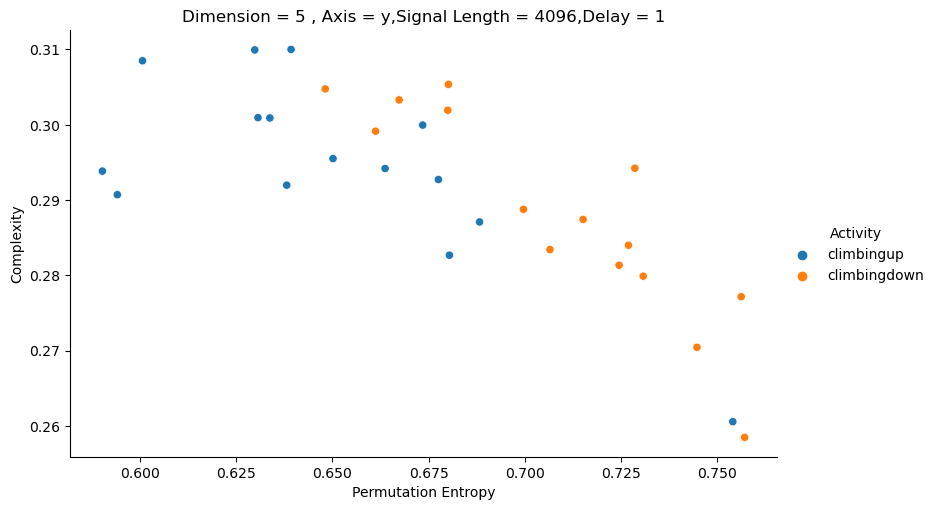

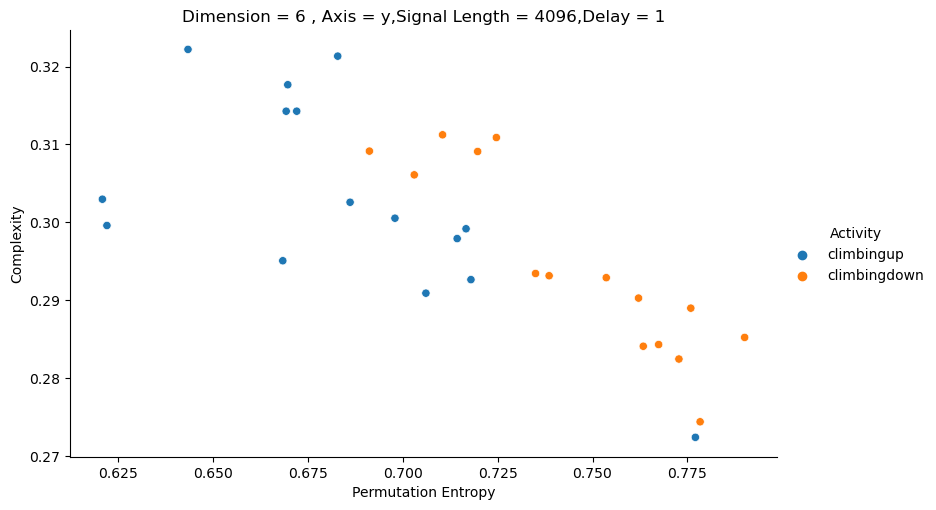

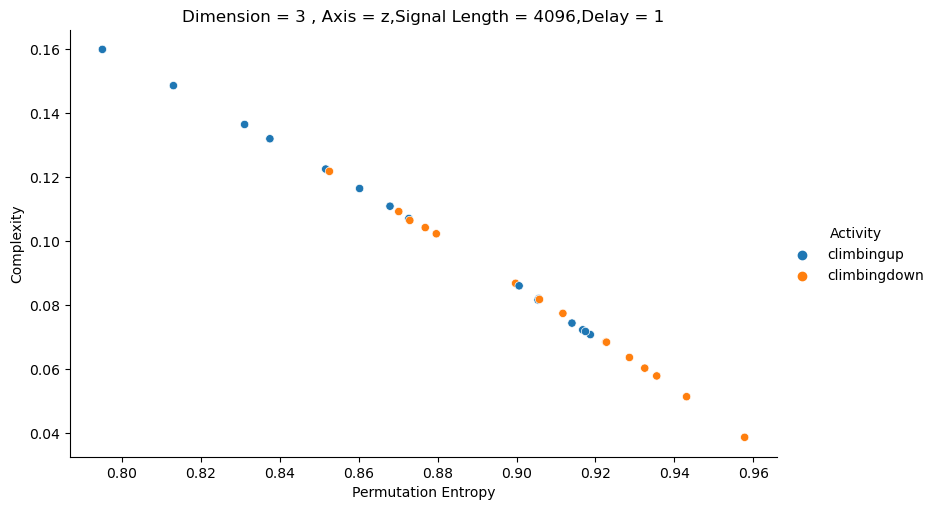

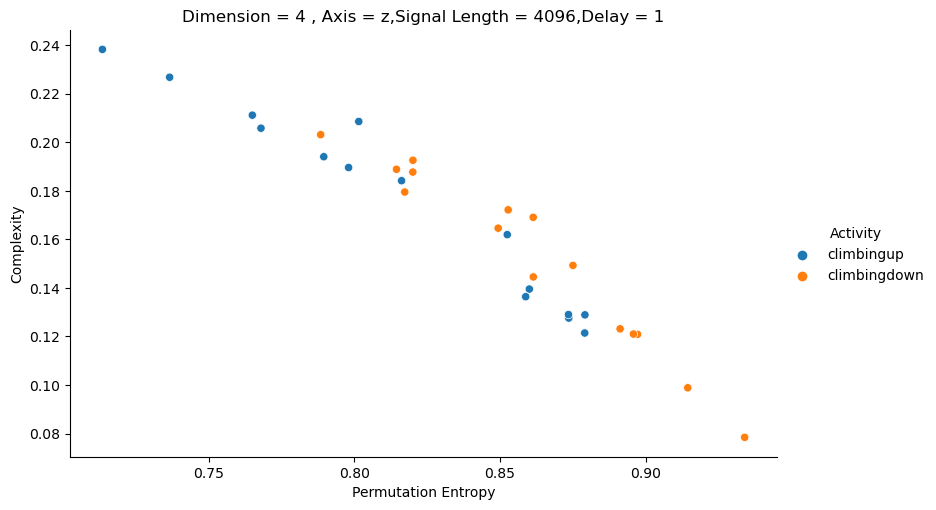

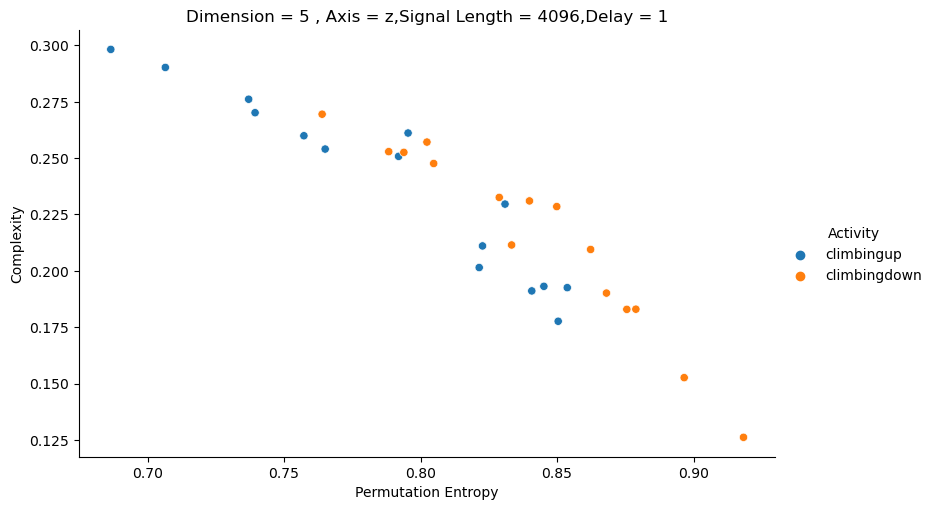

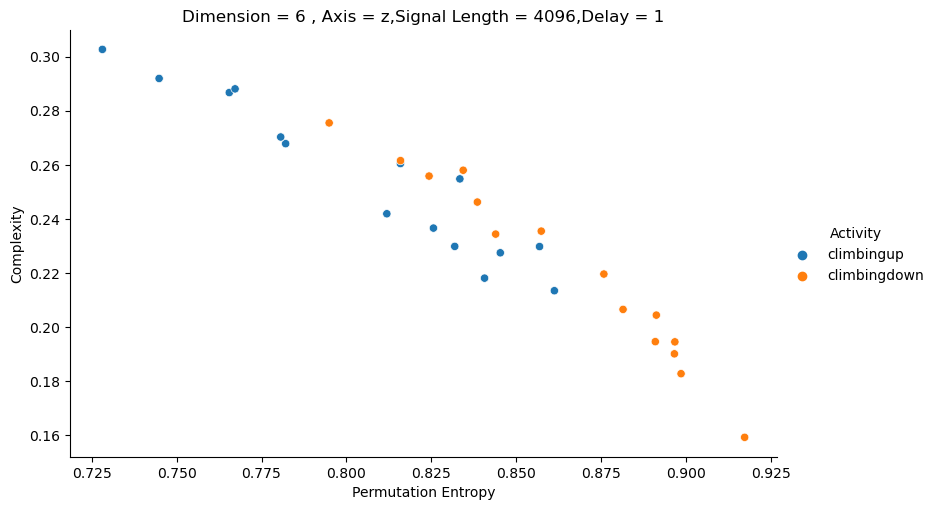

In [8]:
for ax in ['attr_x','attr_y','attr_z']:
    for dim in [3,4,5,6]:
        dff = dffinal[(dffinal['BodyP'] == 'chest') & (dffinal['Signal Length'] == 4096) & (dffinal['Delay'] == 1 ) & (dffinal['Dimension'] == dim ) & (dffinal['Axis'] == ax ) & ((dffinal['Activity'] == 'climbingup') | (dffinal['Activity'] == 'climbingdown'))]
        sns.relplot(data=dff, x='Permutation Entropy', y='Complexity', hue='Activity', aspect=1.61).set(title='Dimension = '+str(dim)+' , Axis = '+ax[5:]+ ',Signal Length = 4096'+',Delay = 1')
    
        plt.show()